In [1]:
import numpy as np
import pandas as pd
import glob
import emcee
import corner
import scipy.stats

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity

from fit_just_early_lc import prep_light_curve

from corner_hack import corner_hack
from light_curve_plot import f_t, plot_both_filt

In [2]:
%matplotlib notebook

In [3]:
info_path="../../forced_lightcurves/sample_lc_v2/"
salt_df = pd.read_csv(info_path + "../../Nobs_cut_salt2_spec_subtype.csv")

In [39]:
### example 

sn = 'ZTF18abauprj'

h5_file = info_path + 'big_unc/{}_emcee_40_varchange.h5'.format(sn)
reader = emcee.backends.HDFBackend(h5_file)
thin_by = 250
nsteps = thin_by*np.shape(reader.get_chain())[0]
tau = reader.get_autocorr_time(tol=0)
burnin = int(5*np.max(tau))
samples = reader.get_chain(discard=burnin, thin=np.max(int(np.max(tau)), 0), flat=True)
lnpost = reader.get_log_prob(discard=burnin, thin=np.max([int(np.max(tau)), 1]), flat=True)

In [40]:
# alpha_g_samples = samples[:,2]

# params = {'bandwidth': np.logspace(-2.5, 0, 2)}
# grid_alpha_g = GridSearchCV(KernelDensity(rtol=1e-1), params, cv=3)
# alpha_g_data = np.reshape(alpha_g_samples, (len(alpha_g_samples), 1))
# grid_alpha_g.fit(alpha_g_data)

# print("best bandwidth: {0}".format(grid_alpha_g.best_estimator_.bandwidth))

# # use the best estimator to compute the kernel density estimate
# kde_alpha_g = grid_alpha_g.best_estimator_

In [41]:
# for bandwidth in range()
alpha_g_samples = samples[:,2]
alpha_g_data = np.reshape(alpha_g_samples, (len(alpha_g_samples), 1))

h = 0.9*len(alpha_g_samples)**(-0.2)*np.min([np.std(alpha_g_samples, ddof=1),
           np.diff(np.percentile(alpha_g_samples, (25,75)))[0]/1.349])
print(h)
kde = KernelDensity(rtol=1e-4, bandwidth = h)
kde.fit(alpha_g_data)
# kde.score(alpha_g_data[50000:])

0.005110554853060833


KernelDensity(algorithm='auto', atol=0, bandwidth=0.005110554853060833,
       breadth_first=True, kernel='gaussian', leaf_size=40,
       metric='euclidean', metric_params=None, rtol=0.0001)

In [42]:
x_grid = np.linspace(0,10,10000)
pdf = kde.score_samples(x_grid.reshape(10000,1))

<IPython.core.display.Javascript object>


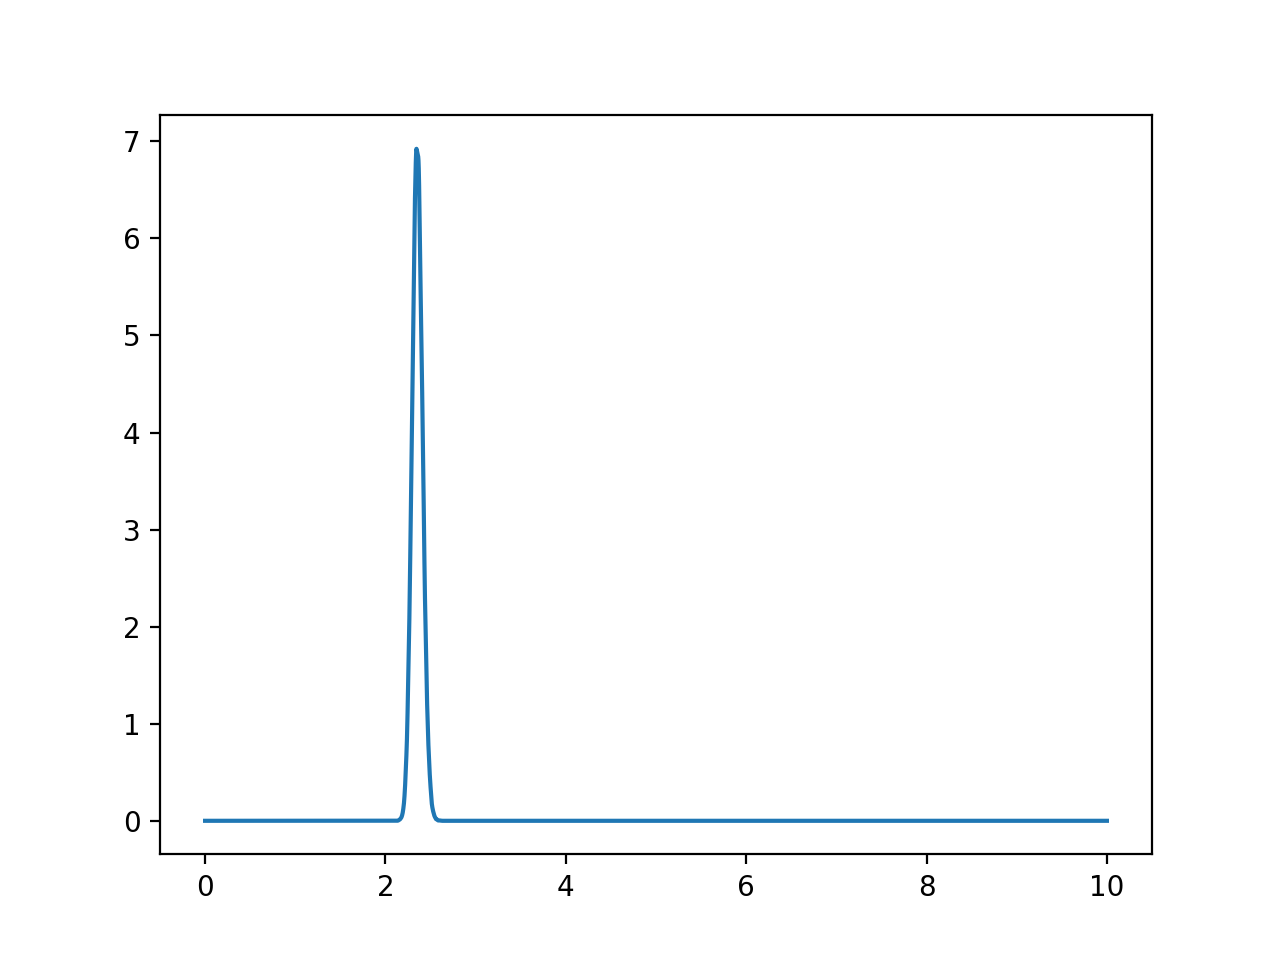

In [44]:
plt.figure()
plt.plot(x_grid, np.exp(pdf))

In [45]:
norm = 1/np.sum(np.exp(pdf)*np.max(x_grid)/len(x_grid))

In [53]:
sn = 'ZTF18aaqffyp'

h5_file = info_path + 'big_unc/{}_emcee_40_varchange.h5'.format(sn)
reader = emcee.backends.HDFBackend(h5_file)
thin_by = 250
nsteps = thin_by*np.shape(reader.get_chain())[0]
tau = reader.get_autocorr_time(tol=0)
burnin = int(5*np.max(tau))
samples = reader.get_chain(discard=burnin, thin=np.max(int(np.max(tau)), 0), flat=True)
lnpost = reader.get_log_prob(discard=burnin, thin=np.max([int(np.max(tau)), 1]), flat=True)

In [56]:
alpha_g_samples = samples[:,2]

params = {'bandwidth': np.logspace(-2.5, 0, 20)}
grid_alpha_g = GridSearchCV(KernelDensity(rtol=1e-4), params, cv=3, n_jobs=4)
alpha_g_data = np.reshape(alpha_g_samples, (len(alpha_g_samples), 1))
grid_alpha_g.fit(alpha_g_data)

print("best bandwidth: {0}".format(grid_alpha_g.best_estimator_.bandwidth))

# use the best estimator to compute the kernel density estimate
kde_alpha_g = grid_alpha_g.best_estimator_

best bandwidth: 0.01438449888287663


/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [61]:
# for bandwidth in range()
alpha_g_samples = samples[:,2]
alpha_g_data = np.reshape(alpha_g_samples, (len(alpha_g_samples), 1))

h = 0.9*len(alpha_g_samples)**(-0.2)*np.min([np.std(alpha_g_samples, ddof=1),
           np.diff(np.percentile(alpha_g_samples, (25,75)))[0]/1.349])
print(h)
kde = KernelDensity(rtol=1e-4, bandwidth = .4)
kde.fit(alpha_g_data)
# kde.score(alpha_g_data[50000:])

0.02131063484735449


KernelDensity(algorithm='auto', atol=0, bandwidth=0.4, breadth_first=True,
       kernel='gaussian', leaf_size=40, metric='euclidean',
       metric_params=None, rtol=0.0001)

<IPython.core.display.Javascript object>


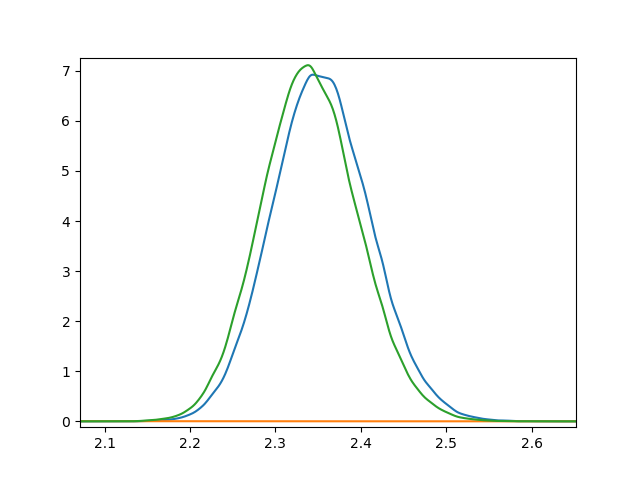

In [64]:
pdf2 = kde.score_samples(x_grid.reshape(10000,1))
norm2 = 1/np.sum(np.exp(pdf2)*np.max(x_grid)/len(x_grid))
plt.figure()
plt.plot(x_grid, np.exp(pdf)*norm)
plt.plot(x_grid, np.exp(pdf2)*norm2)
plt.plot(x_grid, np.exp(pdf)*norm * np.exp(pdf2)*norm2/np.sum(np.exp(pdf)*norm * np.exp(pdf2)*norm2*np.max(x_grid)/len(x_grid)))
# plt.ylim(0,0.2)
# plt.yscale('log')

In [241]:
res = pd.read_csv('results_40percent.csv')

pdf_array_bigh = np.zeros((len(res), 10000))

for sn_num, sn in enumerate(res.ztf_name):
    print(sn)
    h5_file = info_path + 'big_unc/{}_emcee_40_varchange.h5'.format(str(sn[2:-1]))
    reader = emcee.backends.HDFBackend(h5_file)
    thin_by = 250
    nsteps = thin_by*np.shape(reader.get_chain())[0]
    tau = reader.get_autocorr_time(tol=0)
    burnin = int(5*np.max(tau))
    samples = reader.get_chain(discard=burnin, thin=np.max(int(np.max(tau)), 0), flat=True)
    lnpost = reader.get_log_prob(discard=burnin, thin=np.max([int(np.max(tau)), 1]), flat=True)
    
    alpha_g_samples = samples[:,2]
    alpha_g_data = np.reshape(alpha_g_samples, (len(alpha_g_samples), 1))

    h = 0.9*len(alpha_g_samples)**(-0.2)*np.min([np.std(alpha_g_samples, ddof=1),
               np.diff(np.percentile(alpha_g_samples, (25,75)))[0]/1.349])
    print(np.std(alpha_g_samples, ddof=1), np.diff(np.percentile(alpha_g_samples, (25,75)))[0]/1.349)
#     kde = KernelDensity(rtol=1e-4, bandwidth = h)
#     kde.fit(alpha_g_data)
    
#     pdf = kde.score_samples(x_grid.reshape(10000,1))
# #     norm = 1/np.sum(np.exp(pdf)*np.max(x_grid)/len(x_grid))

#     pdf_array_bigh[sn_num] = pdf

b'ZTF18aailmnv'
0.1673233970303444 0.156180471016347
b'ZTF18aansqun'
0.4409235326449479 0.394118031101855
b'ZTF18aaoxryq'
0.20968720487093706 0.2016410458946204
b'ZTF18aapqwyv'
0.41765834460913687 0.38499873343058566
b'ZTF18aapsedq'
0.4998675434226154 0.479892867008815
b'ZTF18aaqcozd'
0.2374534278681944 0.14632669902481957
b'ZTF18aaqcqkv'
0.6448571443740347 0.5357401656560103
b'ZTF18aaqcqvr'
0.10269375314212138 0.09371930132573697
b'ZTF18aaqcugm'
0.15128316805658104 0.14123967009917535
b'ZTF18aaqffyp'
0.29143503082267647 0.20777439275202153
b'ZTF18aaqnrum'
0.6220632119301857 0.43748499048867323
b'ZTF18aaqqoqs'
0.13253212789783872 0.1308667464869748
b'ZTF18aarldnh'
0.2863504340387508 0.2662975675006404
b'ZTF18aarqnje'
0.3107837968780436 0.2999833106969536
b'ZTF18aasdted'
0.033364786073567056 0.032846667326861936
b'ZTF18aasesgl'
0.4616556873273677 0.37946322843285946
b'ZTF18aaslhxt'
0.08391657477786839 0.082214545340197
b'ZTF18aatzygk'
0.7161555191912071 0.5692629364642935
b'ZTF18aauhxce

In [245]:
np.logspace(-2.5, 0, 15)

array([0.00316228, 0.00477058, 0.00719686, 0.01085711, 0.01637894,
       0.02470911, 0.03727594, 0.05623413, 0.08483429, 0.12798022,
       0.19306977, 0.29126327, 0.43939706, 0.66287032, 1.        ])

<IPython.core.display.Javascript object>


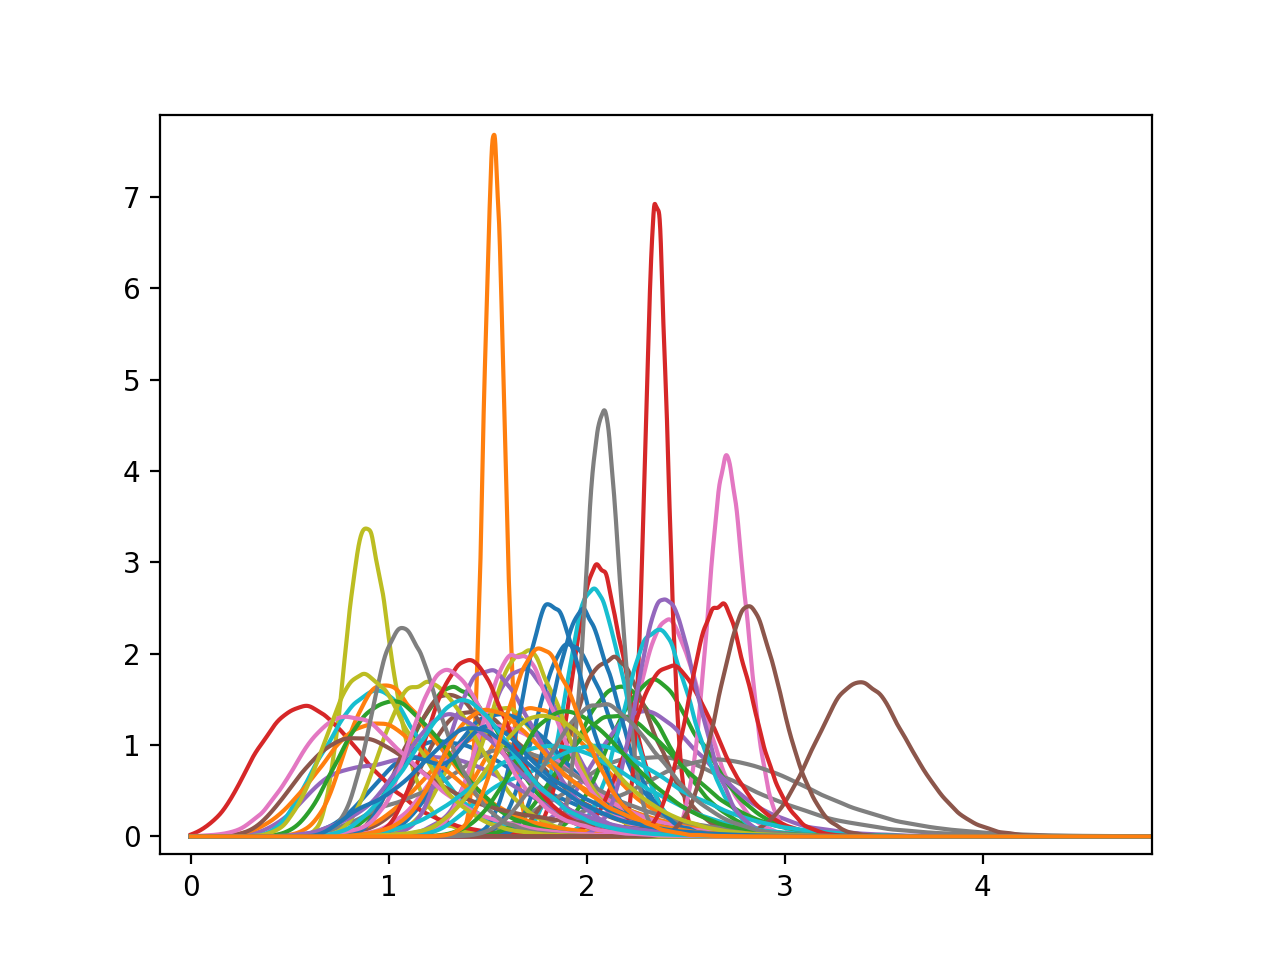

In [203]:
fig, ax = plt.subplots()
for sn_num, kde_pdf in enumerate(pdf_array_bigh):
    if res.final_selection.iloc[sn_num]:
        _ = ax.plot(x_grid, np.exp(kde_pdf))

In [202]:
div_prior = pdf_array_bigh + np.repeat(np.log(10)*x_grid.reshape(1,-1), 127, axis=0)

<IPython.core.display.Javascript object>


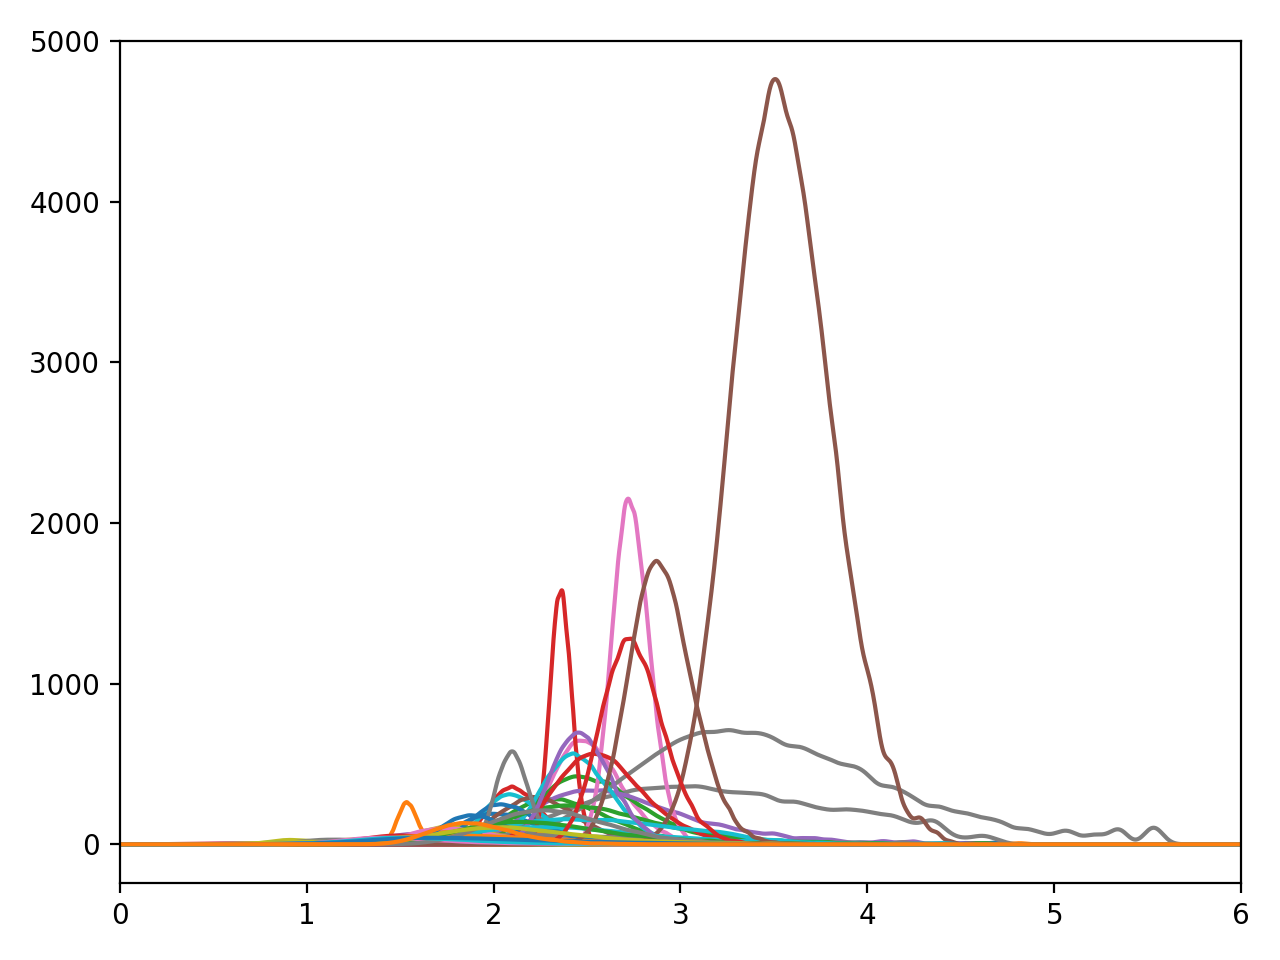

In [205]:
fig, ax = plt.subplots()
for sn_num, kde_pdf in enumerate(div_prior):
    if res.final_selection.iloc[sn_num]:
        _ = ax.plot(x_grid, np.exp(kde_pdf))
ax.set_xlim(0,6)
fig.tight_layout()

In [206]:
norm_likelihood = np.sum(np.exp(div_prior), axis=1)/len(x_grid)*np.ptp(x_grid)
norm_pdf_array = div_prior - np.repeat(np.log(norm_likelihood).reshape(-1,1), len(x_grid), axis=1)

<IPython.core.display.Javascript object>


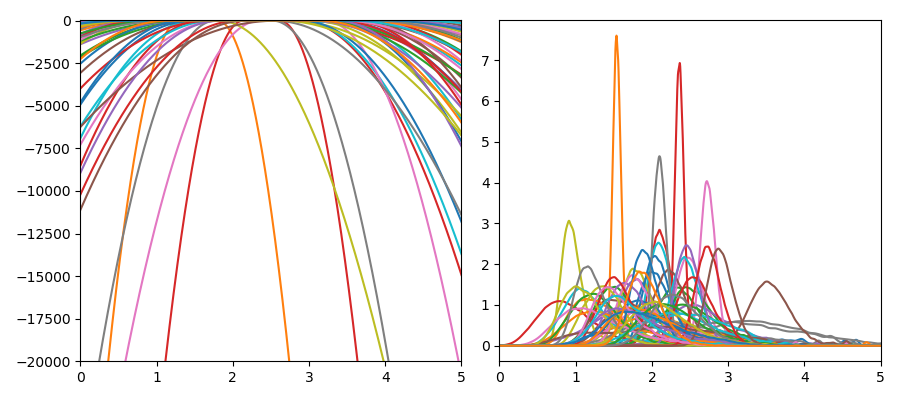

In [246]:
fig, (ax, ax1) = plt.subplots(1,2, figsize=(9,4))
for sn_num, kde_pdf in enumerate(norm_pdf_array):
    if res.final_selection.iloc[sn_num]:
        _ = ax.plot(x_grid, kde_pdf)
        _ = ax1.plot(x_grid, np.exp(kde_pdf))

for a in [ax, ax1]:
    a.set_xlim(0,5)
ax.set_ylim(-20000,25)
fig.tight_layout()

In [223]:
good = np.where(res.final_selection.values == 1)
combined = np.sum(norm_pdf_array, axis=0)
combined_good = np.sum(pdf_array_bigh[good], axis=0)
max(combined)

-3106.382041836241

<IPython.core.display.Javascript object>


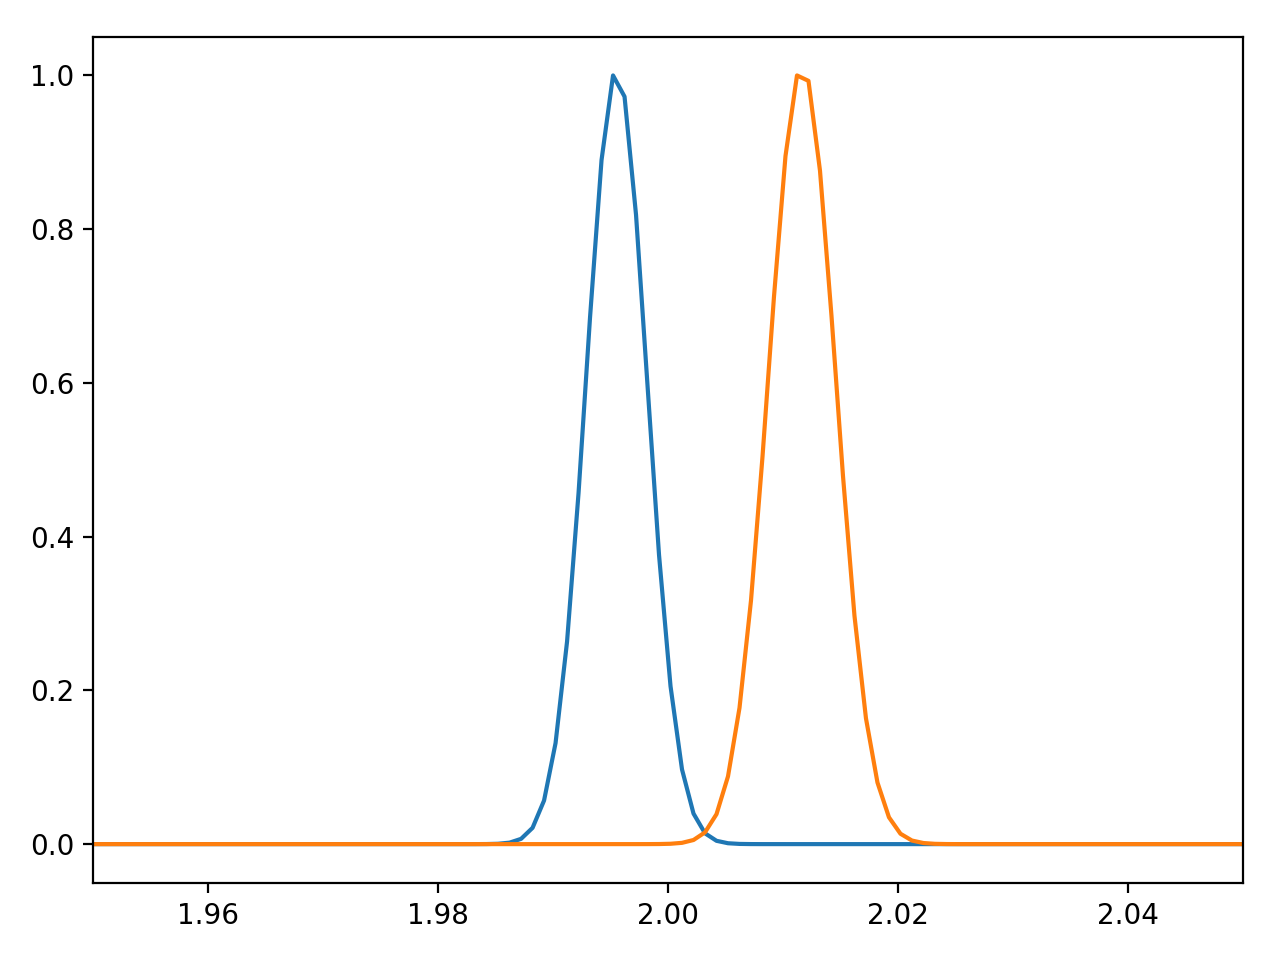

In [229]:
fig, ax  = plt.subplots()
ax.plot(x_grid, np.exp(combined - max(combined)))
ax.plot(x_grid, np.exp(combined_good - max(combined_good)))
ax.set_xlim(1.95, 2.05)
fig.tight_layout()

## Convolve with Gaussian

The below example shows how to "broaden" the rise-time estimations based on the uncertainty on the time of maximum.

In [247]:
from scipy.ndimage import gaussian_filter1d

In [403]:
sn = 'ZTF18abauprj'

h5_file = info_path + 'big_unc/{}_emcee_40_varchange.h5'.format(sn)
reader = emcee.backends.HDFBackend(h5_file)
thin_by = 250
nsteps = thin_by*np.shape(reader.get_chain())[0]
tau = reader.get_autocorr_time(tol=0)
burnin = int(5*np.max(tau))
samples = reader.get_chain(discard=burnin, thin=np.max(int(np.max(tau)), 0), flat=True)
lnpost = reader.get_log_prob(discard=burnin, thin=np.max([int(np.max(tau)), 1]), flat=True)

In [446]:
t_max_unc = salt_df.t0_g_adopted_unc.iloc[np.where(salt_df.name == sn)].values[0]
t_max_unc

0.017790571320801973

In [447]:
t_grid = np.linspace(-25,-5,100000)
t_fl_samples = samples[:,0]
t_fl_data = np.reshape(t_fl_samples, (len(t_fl_samples), 1))

h = 0.9*len(t_fl_samples)**(-0.2)*np.min([np.std(t_fl_samples, ddof=1),
           np.diff(np.percentile(t_fl_samples, (25,75)))[0]/1.349])
print(np.std(t_fl_samples, ddof=1), np.diff(np.percentile(t_fl_samples, (25,75)))[0]/1.349)
kde = KernelDensity(rtol=1e-4, bandwidth = h)
kde.fit(t_fl_data)

pdf = kde.score_samples(t_grid.reshape(100000,1))

0.09808944263265301 0.09725823023821926


In [448]:
prop_unc = gaussian_filter1d(np.exp(pdf), t_max_unc/(np.ptp(t_grid)/len(t_grid)),
                             mode='nearest')

<IPython.core.display.Javascript object>


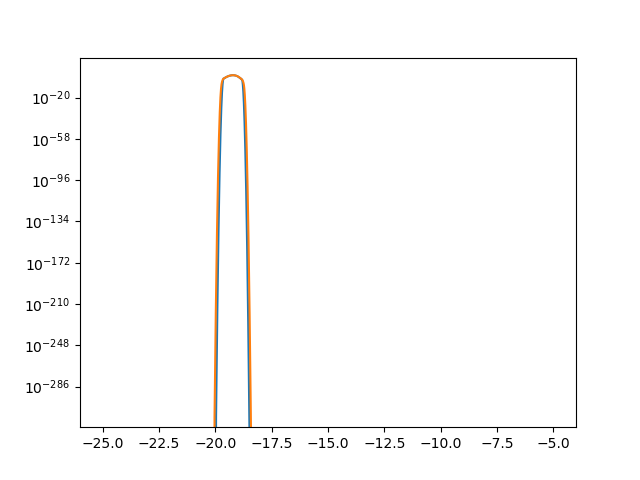

In [458]:
plt.figure()
plt.plot(t_grid, np.exp(pdf))
plt.plot(t_grid, prop_unc)
# plt.xlim(-20,-18.5)
plt.yscale('log')
# plt.plot(t_grid, np.exp(log_prop_unc))

In [452]:
kde_big = KernelDensity(rtol=1e-4, bandwidth = 0.07943282347242814)
kde_big.fit(t_fl_data)

pdf_big = kde_big.score_samples(t_grid.reshape(100000,1))
prop_unc_big = gaussian_filter1d(np.exp(pdf_big), t_max_unc/(np.ptp(t_grid)/len(t_grid)),
                             mode='nearest')

In [463]:
1.5e-320

1.5e-320

<IPython.core.display.Javascript object>


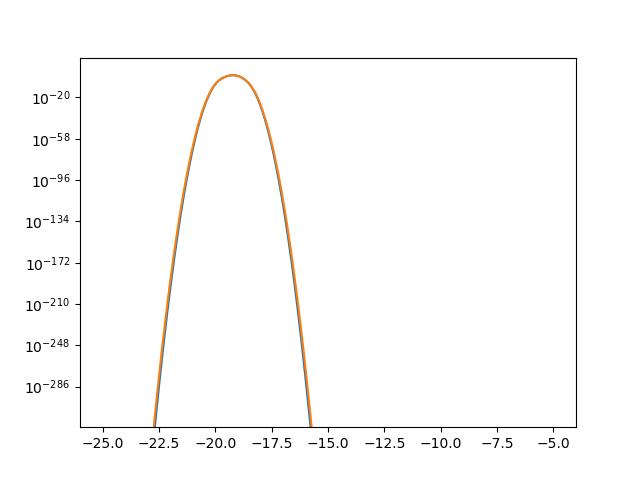

In [457]:
plt.figure()
plt.plot(t_grid, np.exp(pdf_big))
plt.plot(t_grid, prop_unc_big)
# plt.xlim(-20,-18.5)
plt.yscale('log')

## Rise-Time constraints

In [502]:
bw_files = glob.glob('ZTF18*sh.o*')

pdf_array_tfl = np.zeros((len(res), 100000))
prop_unc_arr = np.zeros((len(res), 100000))

def get_pdf(sn):

    bw_file = glob.glob('{}*sh.o*'.format(sn))[0]
    sn_num = np.where(salt_df.name == sn)[0]
    
    with open(bw_file) as f:
        ll = f.readlines()

    h5_file = info_path + 'big_unc/{}_emcee_40_varchange.h5'.format(sn)
    reader = emcee.backends.HDFBackend(h5_file)
    thin_by = 250
    nsteps = thin_by*np.shape(reader.get_chain())[0]
    tau = reader.get_autocorr_time(tol=0)
    burnin = int(5*np.max(tau))
    samples = reader.get_chain(discard=burnin, thin=np.max(int(np.max(tau)), 0), flat=True)

    t_max_unc = salt_df.t0_g_adopted_unc.iloc[np.where(salt_df.name == sn)].values[0]

    t_grid = np.linspace(-25,-5,100000)
    t_fl_samples = samples[:,0]
    t_fl_data = np.reshape(t_fl_samples, (len(t_fl_samples), 1))

    bw = float(ll[0].split(' ')[0])

    kde = KernelDensity(rtol=1e-4, bandwidth = bw)
    kde.fit(t_fl_data)

    pdf = kde.score_samples(t_grid.reshape(100000,1))
    
    prop_unc = gaussian_filter1d(np.exp(pdf), t_max_unc/(np.ptp(t_grid)/len(t_grid)),
                             mode='nearest')

    pdf_array_tfl[sn_num] = pdf
    prop_unc_arr[sn_num] = prop_unc
    
    return (pdf, prop_unc)

from multiprocessing import Pool
import time

pool = Pool(4)

t_fl_res = pool.map(get_pdf, salt_df.name.values)

In [575]:
pdf_array_tfl = np.array(t_fl_res)[:,0]
prop_unc_arr = np.array(t_fl_res)[:,1]

norm_likelihood = np.sum(prop_unc_arr, axis=1)/len(t_grid)*np.ptp(t_grid)
norm_pdf_array = np.log(prop_unc_arr) - np.repeat(np.log(norm_likelihood).reshape(-1,1), len(t_grid), axis=1)

/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


In [546]:
mean_fl = np.sum(norm_pdf_array, axis=0)

norm_mean = np.sum(np.exp(mean_fl - np.max(mean_fl)))/len(t_grid)*np.ptp(t_grid)
mean_pdf_tfl = mean_fl - np.max(mean_fl) - np.repeat(np.log(norm_mean), len(t_grid))

In [595]:
normal = np.where((salt_df['Ia subtype'] != 'Ia-CSM') & 
                  (salt_df['Ia subtype'] != 'SC') & 
                  (salt_df['Ia subtype'] != '86G-like') & 
                  (salt_df['Ia subtype'] != '02cx-like'))
good = np.where(res.final_selection.values == 1)
has_host_z = np.where(salt_df.z_source != 'Msl')

normal_good = np.intersect1d(normal, good)
normal_good_host = np.intersect1d(normal_good, has_host_z)

In [598]:
len(normal_good_host)

27

<IPython.core.display.Javascript object>


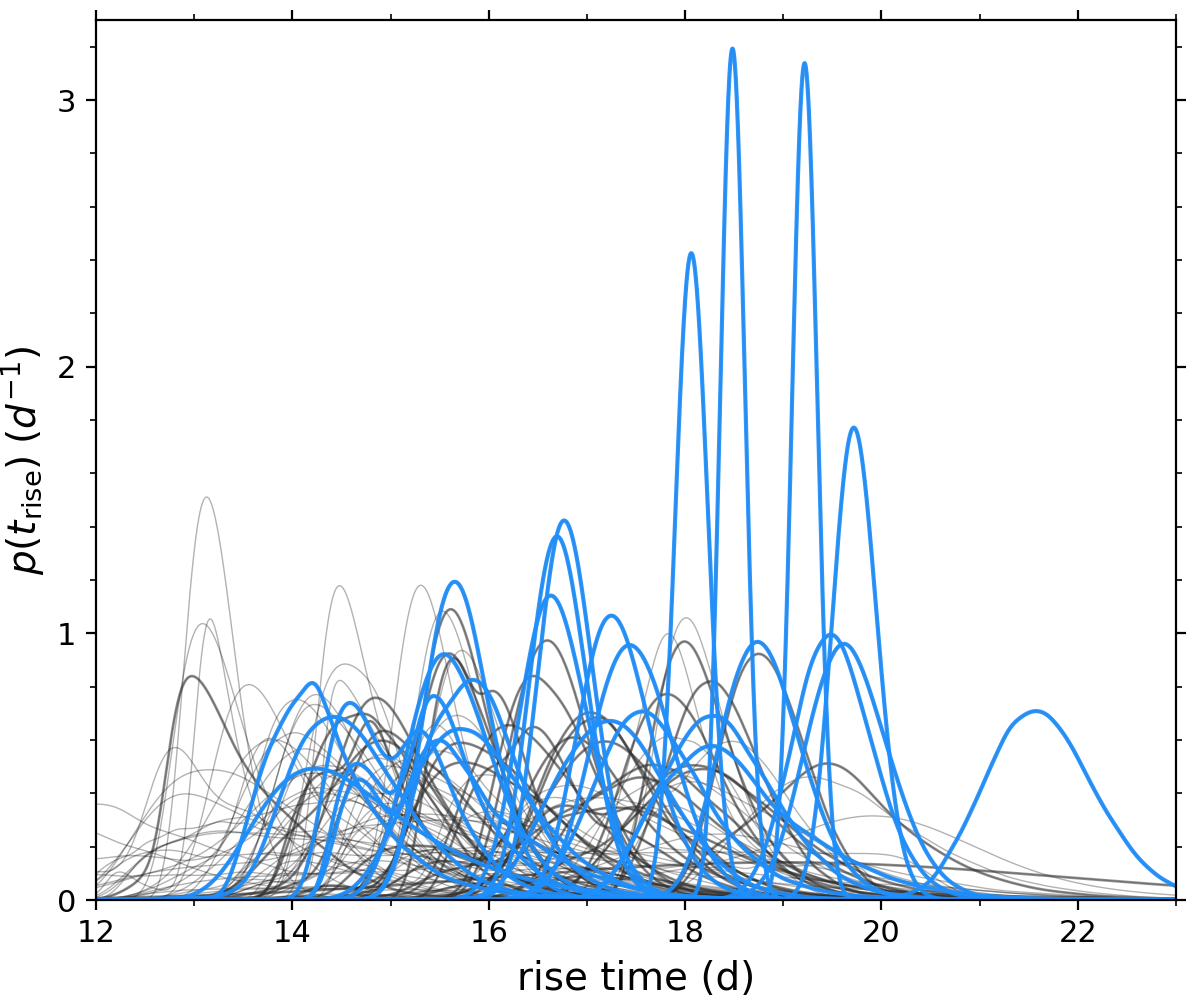

In [600]:
fig, ax = plt.subplots(figsize=(6,5))
for pdf_tfl in norm_pdf_array[normal]:
    ax.plot(-1*t_grid[::-1], np.exp(pdf_tfl[::-1]), 
            'k', lw=0.5, alpha=0.3)
for pdf_tfl in norm_pdf_array[normal_good]:
    ax.plot(-1*t_grid[::-1], np.exp(pdf_tfl[::-1]), 
            '0.2', lw=1, alpha=0.5)
for pdf_tfl in norm_pdf_array[normal_good_host]:
    ax.plot(-1*t_grid[::-1], np.exp(pdf_tfl[::-1]), 
            'DodgerBlue', lw=1.5, alpha=0.9)
    
# plt.plot(t_grid, mean_pdf_tfl, 'k', lw=1)
# plt.yscale('log')
ax.set_xlim(12,23)
ax.set_ylim(0,3.3)
ax.set_xlabel('rise time (d)',fontsize=14)
ax.set_ylabel(r'$p(t_\mathrm{rise}) \; (d^{-1})$',fontsize=14)

ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.xaxis.set_major_locator(MultipleLocator(2))
ax.yaxis.set_minor_locator(MultipleLocator(0.2))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.tick_params(right=True, top=True, bottom=True, which='both', labelsize=11)

fig.subplots_adjust(left=0.08,bottom=0.1,top=0.98,right=0.98)
fig.savefig('rise_time.pdf')

In [565]:
salt_df['Ia subtype'].unique()

array(['normal', 'normal*', '99aa-like', 'SC*', '91T-like*', 'Ia-CSM',
       '02cx-like', '86G-like', 'SC', '99aa-like*', '91T-like'],
      dtype=object)

## $\alpha_g$ constraints

In [601]:
alpha_grid = np.linspace(0,10,100000)

def get_pdf(sn):

    bw_file = glob.glob('{}*sh.o*'.format(sn))[0]
    sn_num = np.where(salt_df.name == sn)[0]
    
    with open(bw_file) as f:
        ll = f.readlines()

    h5_file = info_path + 'big_unc/{}_emcee_40_varchange.h5'.format(sn)
    reader = emcee.backends.HDFBackend(h5_file)
    thin_by = 250
    nsteps = thin_by*np.shape(reader.get_chain())[0]
    tau = reader.get_autocorr_time(tol=0)
    burnin = int(5*np.max(tau))
    samples = reader.get_chain(discard=burnin, thin=np.max(int(np.max(tau)), 0), flat=True)

    alpha_grid = np.linspace(0,10,100000)
    alpha_g_samples = samples[:,2]
    alpha_g_data = np.reshape(alpha_g_samples, (len(alpha_g_samples), 1))

    bw = float(ll[1].split(' ')[0])

    kde = KernelDensity(rtol=1e-4, bandwidth = bw)
    kde.fit(alpha_g_data)

    pdf = kde.score_samples(alpha_grid.reshape(100000,1))
    
    
    return pdf

pool = Pool(4)

alpha_g_res = pool.map(get_pdf, salt_df.name.values)

In [670]:
pdf_array_alpha_g = np.array(alpha_g_res)

# divide out the prior
div_prior = pdf_array_alpha_g + np.repeat(np.log(10)*alpha_grid.reshape(1,-1), 127, axis=0)

norm_likelihood = np.sum(np.exp(div_prior), axis=1)/len(alpha_grid)*np.ptp(alpha_grid)
norm_pdf_array = div_prior - np.repeat(np.log(norm_likelihood).reshape(-1,1), len(alpha_grid), axis=1)

<IPython.core.display.Javascript object>


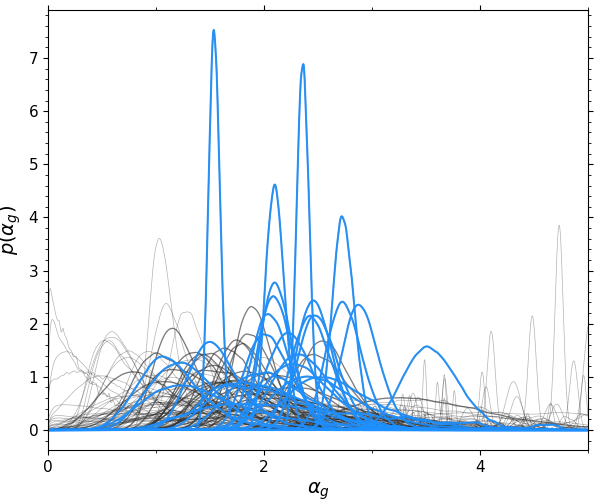

In [671]:
fig, ax = plt.subplots(figsize=(6,5))
for pdf in norm_pdf_array[normal]:
    ax.plot(alpha_grid, np.exp(pdf),
            'k', lw=0.5, alpha=0.3)
for pdf in norm_pdf_array[normal_good]:
    ax.plot(alpha_grid, np.exp(pdf),
            '0.2', lw=1, alpha=0.5)
for pdf in norm_pdf_array[normal_good_host]:
    ax.plot(alpha_grid, np.exp(pdf),
            'DodgerBlue', lw=1.5, alpha=0.9)

    
ax.set_xlim(0,5)
# ax.set_ylim(0,3.3)
ax.set_xlabel(r'$\alpha_g$',fontsize=14)
ax.set_ylabel(r'$p(\alpha_g)$',fontsize=14)

ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.xaxis.set_major_locator(MultipleLocator(2))
ax.yaxis.set_minor_locator(MultipleLocator(0.2))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.tick_params(right=True, top=True, bottom=True, which='both', labelsize=11)

fig.subplots_adjust(left=0.08,bottom=0.1,top=0.98,right=0.98)
fig.savefig('alpha_g.pdf')

##  $\alpha_r$ constraints

In [616]:
def get_pdf(sn):

    bw_file = glob.glob('{}*sh.o*'.format(sn))[0]
    sn_num = np.where(salt_df.name == sn)[0]
    
    with open(bw_file) as f:
        ll = f.readlines()

    h5_file = info_path + 'big_unc/{}_emcee_40_varchange.h5'.format(sn)
    reader = emcee.backends.HDFBackend(h5_file)
    thin_by = 250
    nsteps = thin_by*np.shape(reader.get_chain())[0]
    tau = reader.get_autocorr_time(tol=0)
    burnin = int(5*np.max(tau))
    samples = reader.get_chain(discard=burnin, thin=np.max(int(np.max(tau)), 0), flat=True)

    alpha_grid = np.linspace(0,10,100000)
    alpha_r_samples = samples[:,4]
    alpha_r_data = np.reshape(alpha_r_samples, (len(alpha_r_samples), 1))

    bw = float(ll[2].split(' ')[0])

    kde = KernelDensity(rtol=1e-4, bandwidth = bw)
    kde.fit(alpha_r_data)

    pdf = kde.score_samples(alpha_grid.reshape(100000,1))
    
    
    return pdf

pool = Pool(4)

alpha_r_res = pool.map(get_pdf, salt_df.name.values)

In [672]:
pdf_array_alpha_r = np.array(alpha_r_res)

# divide out the prior
div_prior = pdf_array_alpha_r + np.repeat(np.log(10)*alpha_grid.reshape(1,-1), 127, axis=0)

norm_likelihood = np.sum(np.exp(div_prior), axis=1)/len(alpha_grid)*np.ptp(alpha_grid)
norm_pdf_array = div_prior - np.repeat(np.log(norm_likelihood).reshape(-1,1), len(alpha_grid), axis=1)

<IPython.core.display.Javascript object>


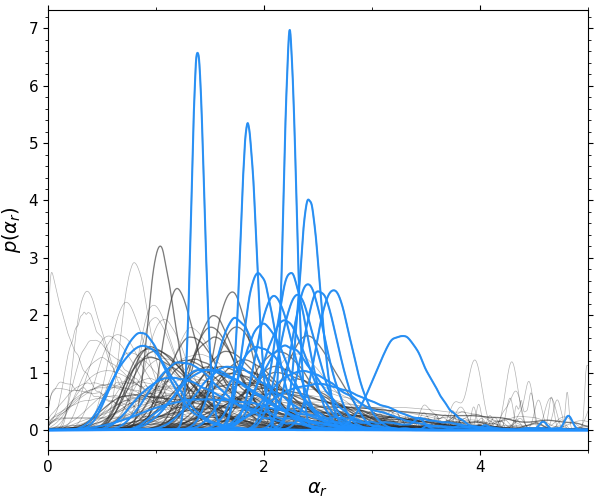

In [673]:
fig, ax = plt.subplots(figsize=(6,5))
for pdf in norm_pdf_array[normal]:
    ax.plot(alpha_grid, np.exp(pdf),
            'k', lw=0.5, alpha=0.3)
for pdf in norm_pdf_array[normal_good]:
    ax.plot(alpha_grid, np.exp(pdf),
            '0.2', lw=1, alpha=0.5)
for pdf in norm_pdf_array[normal_good_host]:
    ax.plot(alpha_grid, np.exp(pdf),
            'DodgerBlue', lw=1.5, alpha=0.9)

    
ax.set_xlim(0,5)
# ax.set_ylim(0,3.3)
ax.set_xlabel(r'$\alpha_r$',fontsize=14)
ax.set_ylabel(r'$p(\alpha_r)$',fontsize=14)

ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.xaxis.set_major_locator(MultipleLocator(2))
ax.yaxis.set_minor_locator(MultipleLocator(0.2))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.tick_params(right=True, top=True, bottom=True, which='both', labelsize=11)

fig.subplots_adjust(left=0.08,bottom=0.1,top=0.98,right=0.98)
fig.savefig('alpha_r.pdf')

## $\Delta \alpha$

In [621]:
delta_grid = np.linspace(-3,3,100000)

def get_pdf(sn):

    bw_file = glob.glob('{}*sh.o*'.format(sn))[0]
    sn_num = np.where(salt_df.name == sn)[0]
    
    with open(bw_file) as f:
        ll = f.readlines()

    h5_file = info_path + 'big_unc/{}_emcee_40_varchange.h5'.format(sn)
    reader = emcee.backends.HDFBackend(h5_file)
    thin_by = 250
    nsteps = thin_by*np.shape(reader.get_chain())[0]
    tau = reader.get_autocorr_time(tol=0)
    burnin = int(5*np.max(tau))
    samples = reader.get_chain(discard=burnin, thin=np.max(int(np.max(tau)), 0), flat=True)

    delta_grid = np.linspace(-3,3,100000)
    delta_samples = samples[:,4] - samples[:,2]
    delta_data = np.reshape(delta_samples, (len(delta_samples), 1))

    bw = float(ll[3].split(' ')[0])

    kde = KernelDensity(rtol=1e-4, bandwidth = bw)
    kde.fit(delta_data)

    pdf = kde.score_samples(delta_grid.reshape(100000,1))
    
    
    return pdf

pool = Pool(4)

delta_res = pool.map(get_pdf, salt_df.name.values)

In [674]:
pdf_array_delta = np.array(delta_res)

# divide out the prior
div_prior = pdf_array_delta + np.repeat(np.log(10)*delta_grid.reshape(1,-1), 127, axis=0)

norm_likelihood = np.sum(np.exp(div_prior), axis=1)/len(delta_grid)*np.ptp(delta_grid)
norm_pdf_array = div_prior - np.repeat(np.log(norm_likelihood).reshape(-1,1), len(delta_grid), axis=1)

<IPython.core.display.Javascript object>


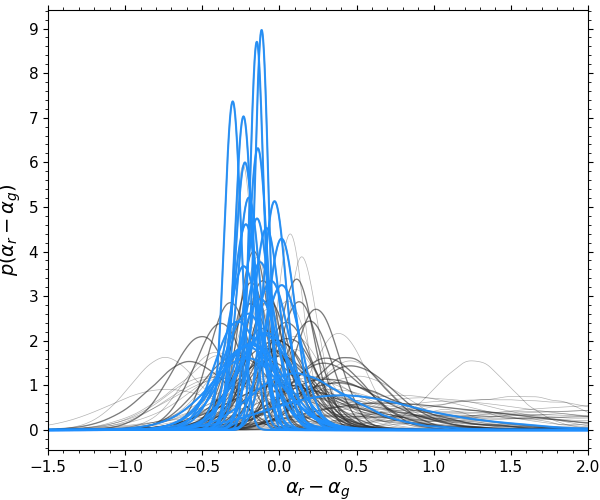

In [675]:
fig, ax = plt.subplots(figsize=(6,5))
for pdf in norm_pdf_array[normal]:
    ax.plot(delta_grid, np.exp(pdf),
            'k', lw=0.5, alpha=0.3)
for pdf in norm_pdf_array[normal_good]:
    ax.plot(delta_grid, np.exp(pdf),
            '0.2', lw=1, alpha=0.5)
for pdf in norm_pdf_array[normal_good_host]:
    ax.plot(delta_grid, np.exp(pdf),
            'DodgerBlue', lw=1.5, alpha=0.9)

    
ax.set_xlim(-1.5,2)
# ax.set_ylim(0,3.3)
ax.set_xlabel(r'$\alpha_r - \alpha_g$',fontsize=14)
ax.set_ylabel(r'$p(\alpha_r - \alpha_g)$',fontsize=14)

ax.xaxis.set_minor_locator(MultipleLocator(0.1))
ax.xaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_minor_locator(MultipleLocator(0.2))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.tick_params(right=True, top=True, bottom=True, which='both', labelsize=11)

fig.subplots_adjust(left=0.08,bottom=0.1,top=0.98,right=0.98)
fig.savefig('delta.pdf')

In [645]:
mean_delta = np.sum(norm_pdf_array[normal_good_host], axis=0)

norm_mean = np.sum(np.exp(mean_delta))/len(delta_grid)*np.ptp(delta_grid)
mean_pdf_delta = mean_delta - np.repeat(np.log(norm_mean), len(delta_grid))

<IPython.core.display.Javascript object>


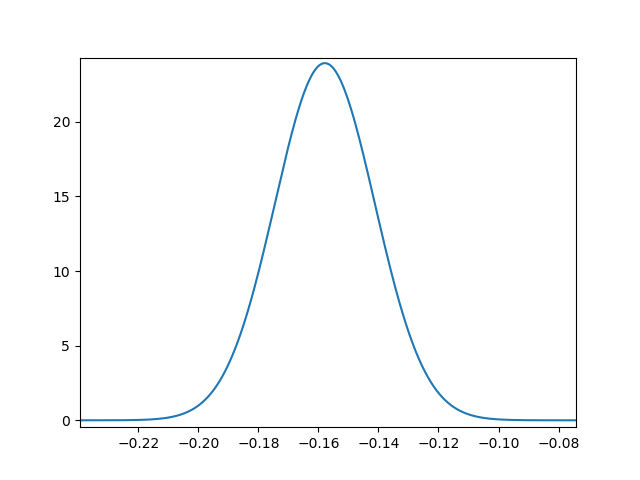

In [646]:
plt.figure()
plt.plot(delta_grid, np.exp(mean_pdf_delta))

<IPython.core.display.Javascript object>


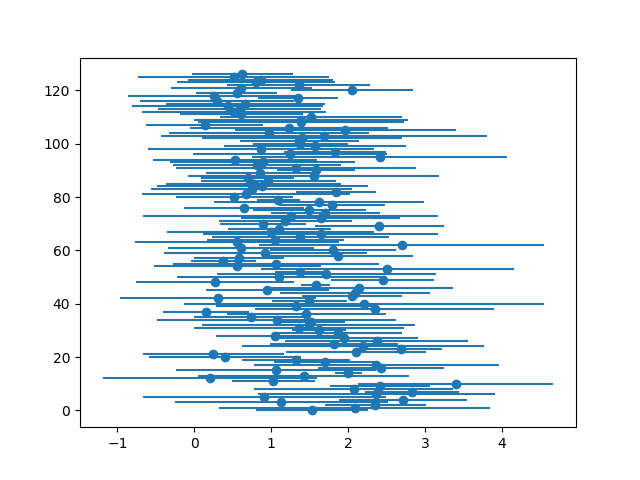

<ErrorbarContainer object of 3 artists>

In [651]:
cr_90_alpha_g = res.alpha_g_95 - res.alpha_g_05

plot_order = np.argsort(salt_df.z_adopt.values)

plt.figure()
plt.errorbar(res.alpha_g.values[plot_order], np.arange(len(res.alpha_g)), xerr=cr_90_alpha_g, fmt='o')

<IPython.core.display.Javascript object>


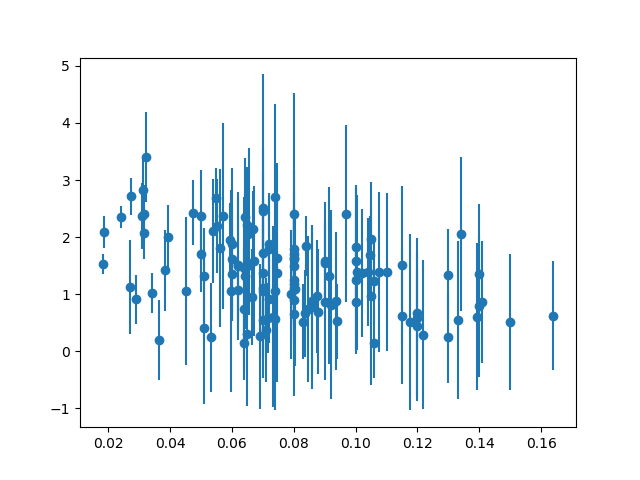

<ErrorbarContainer object of 3 artists>

In [653]:
plt.figure()
plt.errorbar(salt_df.z_adopt.values, res.alpha_g.values, yerr=cr_90_alpha_g, fmt='o')

In [684]:
np.shape(cr_90[:,normal])

(2, 1, 122)

<IPython.core.display.Javascript object>


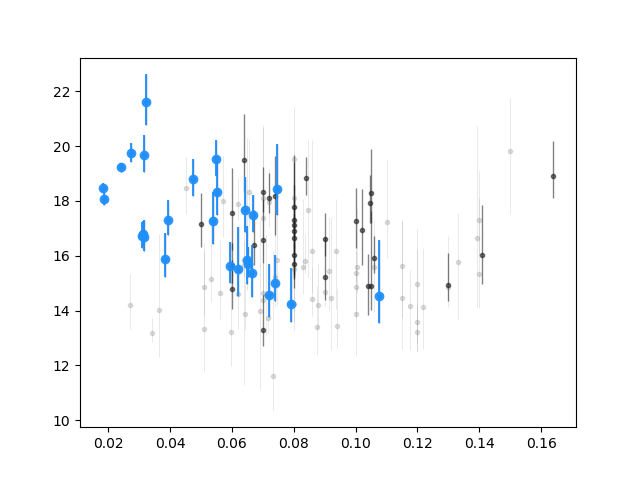

<ErrorbarContainer object of 3 artists>

In [690]:
cr_90_t_fl = res.t0_95.values - res.t0_05.values

cr_90 = np.vstack([res.t0_95.values - res.t0.values, res.t0.values - res.t0_05.values])

plt.figure()
plt.errorbar(salt_df.z_adopt.values[normal], -1*res.t0.values[normal], 
             yerr=cr_90[:,normal[0]], fmt='.', 
              color='0.4', lw=0.5, alpha=0.2)
plt.errorbar(salt_df.z_adopt.values[normal_good], -1*res.t0.values[normal_good], 
             yerr=cr_90[:,normal_good], fmt='.',
             color='0.1', lw=1, alpha=0.5)
plt.errorbar(salt_df.z_adopt.values[normal_good_host], -1*res.t0.values[normal_good_host], 
             yerr=cr_90[:,normal_good_host], fmt='o', 
             color='DodgerBlue', lw=1.5, alpha=0.9, zorder=10)

In [667]:
np.where(salt_df.z_adopt > 0.16)

(array([61]),)

In [668]:
salt_df.iloc[61]

name                            ZTF18abddmrf
z_Marshall                             0.164
z_NED                                   -999
ra_recenter                          226.967
dec_recenter                         38.0484
t0_SALT_adam_jd                  2.45831e+06
E_B_V_SandF                           0.0119
z_Caltech                               -999
z_adopt                                0.164
z_source                                 Msl
z_adopt_unc                            0.005
t0_B_salt2                       2.45831e+06
t0_g_salt2                        2.4583e+06
t0_r_salt2                       2.45831e+06
x0_salt2                         6.21369e-15
x1_salt2                             2.52704
c_salt2                            0.0841905
fratio_gmax_2adam                1.39739e-08
fratio_rmax_2adam                  1.491e-08
t0_salt2_unc                        0.211431
x0_salt2_unc                     4.29247e-16
x1_salt2_unc                        0.936567
c_salt2_un